In [15]:
import numpy as np
import logging
import os
import F21DataLoader as dl
import f21_predict_base as base\n",
    "import plot_results as pltr
import Scaling
import PS1D
import F21Stats as f21stats

import numpy as np
import sys
import os

logger = logging.Logger('M')

def load_dataset(datafiles, psbatchsize, max_workers=8):
    # Lists to store combined data
    all_params = []
    # Create processor with desired number of worker threads
    processor = dl.F21DataLoader(max_workers=max_workers, psbatchsize=psbatchsize, use_bispectrum=True, skip_stats=True, ps_log_bins=True, ps_bins=16, perc_bins_to_use=100, scale_ps=True)

    # Process all files and get results
    results = processor.process_all_files(datafiles)
    logger.info(f"Finished data loading.")
    # Access results
    keys = results['key']
    ps = results['ps']
    ks = results['ks']
    bispec = results['bispectrum']
    k_bispec = results['k_bispec']
    params = results['params']
    freq_axis = results['freq_axis']
    logger.info(f"sample ps:{ps[0]}")
    logger.info(f"sample ks:{ks[0]}")
    logger.info(f"sample bispec:{bispec[0]}")
    logger.info(f"sample k_bispec:{k_bispec[0]}")
    logger.info(f"sample params:{params[0]}")
    
    # Combine all data
    logger.info(f"\nCombined ps shape: {ps.shape}")
    logger.info(f"\nCombined ks shape: {ks.shape}")
    logger.info(f"\nCombined bispec shape: {bispec.shape}")
    logger.info(f"\nCombined k_bispec shape: {k_bispec.shape}")
    logger.info(f"Combined parameters shape: {params.shape}")
            
    return (ks, ps, k_bispec, bispec, params, keys, freq_axis)

def dump_ps(datafile, dir, psbatchsize, save_ks):
    file_name = os.path.basename(datafile)  # Extract the filename from the path
    file_name_no_ext = os.path.splitext(file_name)[0]  # Remove the extension

    ks, ps, k_bispec, bispec, params, keys, freq_axis = load_dataset([datafile], max_workers=1, psbatchsize=1)

    if psbatchsize > 1:
        
        # need to aggregate. use the specified aggregation
        n_batches = len(ps) // psbatchsize
        ps_batched = np.zeros((n_batches, ps.shape[1]))
        bispec_batched = np.zeros((n_batches, bispec.shape[1]))
        for i in range(n_batches):
            if args.aggtype.lower() == 'mean':
                ps_batched[i,:] = np.nanmean(ps[i*psbatchsize:(i+1)*psbatchsize], axis=0)
                bispec_batched[i,:] = np.nanmean(bispec[i*psbatchsize:(i+1)*psbatchsize], axis=0)
            elif args.aggtype.lower() == 'median':
                ps_batched[i,:] = np.nanmedian(ps[i*psbatchsize:(i+1)*psbatchsize], axis=0)
                bispec_batched[i,:] = np.nanmedian(bispec[i*psbatchsize:(i+1)*psbatchsize], axis=0)
            else:
                raise ValueError(f"Invalid aggregation type: {args.aggtype}. Use 'mean' or 'median'")
    ps = ps_batched
    bispec = bispec_batched
    if save_ks:
        logger.info(f'Saving PS, bispec data. PS shape:{ps.shape}, ks shape:{ks.shape}, bispec shape: {bispec.shape}, k_bispec shape: {k_bispec.shape}')
        np.savetxt(f'{dir}/ks_bin.csv', np.hstack((ks, k_bispec))[0])
        logger.info(f" Saved 'k' bin values to f'{dir}/ks_bin.csv'")
    # Save the PS output to a file
    ps_file = f'{dir}/{file_name_no_ext}.csv' 
    np.savetxt(ps_file, np.hstack((ps, bispec)))
    logger.info(f" Saved PS, bispec to {ps_file}")


In [17]:
class Args:
    def __init__(self, runmode='', telescope='uGMRT', t_int=500):
        self.runmode = runmode
        self.telescope = telescope
        self.t_int = t_int
        self.scale_y = True
        self.aggtype = 'median'

args = Args() 

dump_ps('../data/21cmFAST_los/F21_noisy/F21_signalonly_21cmFAST_200Mpc_z6.0_fX-2.00_xHI0.44_8kHz.dat', './tmp_out', 1000, False)


loaded data shape: (50000, 4)


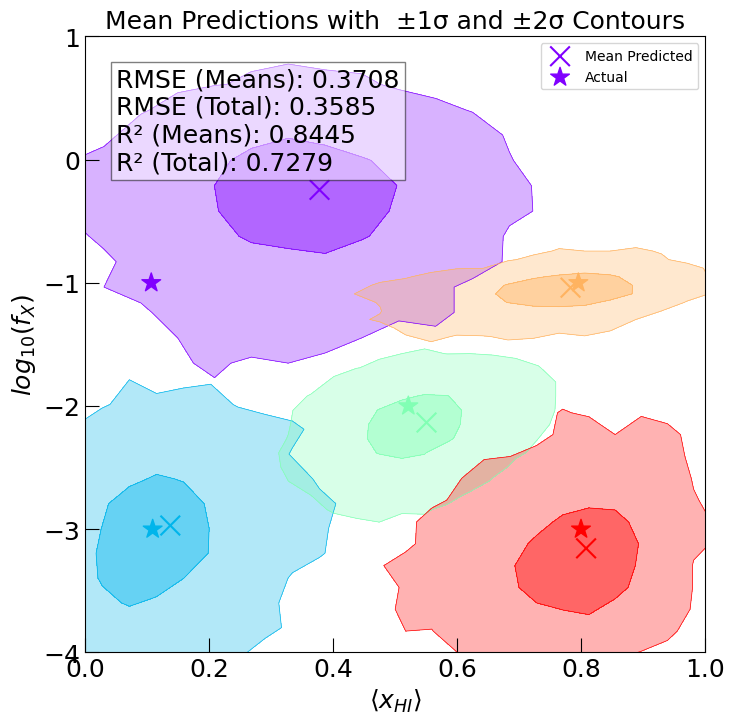

/Users/meghapatil/Documents/Sameer/Physics/girish-kulkarni/Code/21cm-forest/code/f21_predict_base.py:446: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  # Calculate RMSE scores


<Figure size 800x800 with 0 Axes>

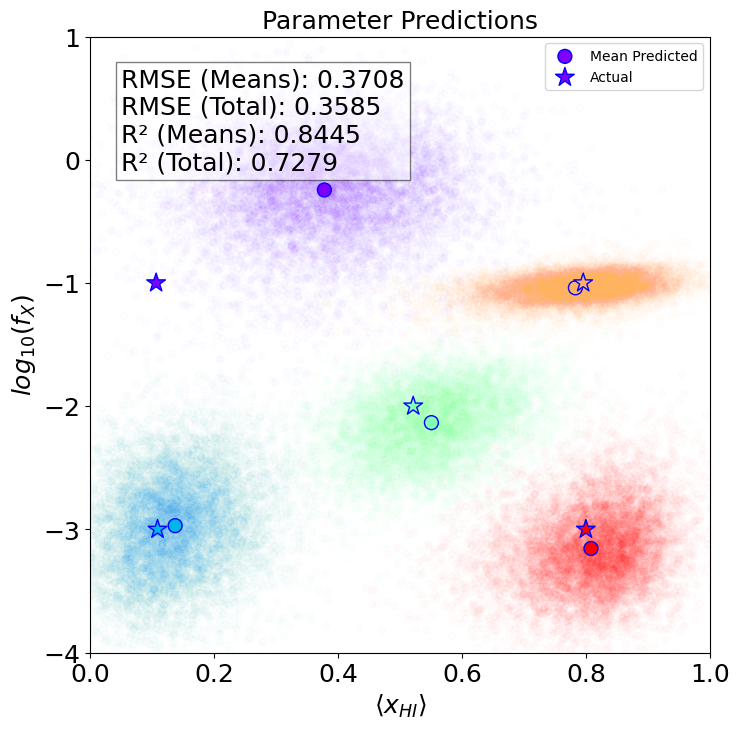

0.844528777014559

In [20]:
import f21_predict_base as base\n",
    "import plot_results as pltr

all_results = np.loadtxt("saved_output/unet_inference/test_results.csv", delimiter=",", skiprows=1)
print(f"loaded data shape: {all_results.shape}")
y_pred = all_results[:,:2]
y_test = all_results[:,2:4]
pltr.summarize_test_1000(y_pred, y_test, showplots=True, saveplots=False)
